# This code finds the percentage of suspicious indels in both datasets that are in LCR 

This code below finds the intersecting regions between gnomAD and IGM data sets. 

The intersecting regions are regions that are suspicious in both the gnomAD and IGM data sets.

In [17]:
system("df_name_1='gnomAD'
df_name_2='IGM'

bp_range=('10' '20' '30' '40')

date=''
output_path=''


for i in ${bp_range[@]};
do
   echo $i
   bedtools intersect -a ${output_path}gnomad.exomes.r2.1.1.sites_indelsonly_rAF_bp${i}_SuspiciousIndels.lt50bp.bin.bed -b ${output_path}2023-03-23_IGM_n39367_indelsonly_rAF_bp${i}_SuspiciousIndels.lt50bp.bin.bed | sort -k1,1n -k2,2n | uniq > ${output_path}${date}_sus_by_both_dfs_bp${i}.bed

done;", intern = TRUE)

[1] "10" "20" "30" "40"

This code below is to find the overlap of the intersecting suspicious regions with LCR. 

In [18]:
system("df_name_1='gnomAD'
df_name_2='IGM'

date=''
output_path=''

bp_range=('10' '20' '30' '40')

lcr_file='GRCh37_AllTandemRepeatsandHomopolymers_slop5.bed'

for i in ${bp_range[@]};
do
    echo $i
    bedtools intersect -wa -a ${output_path}${date}_sus_by_both_dfs_bp${i}.bed -b ${output_path}${lcr_file} | sort -k1,1n -k2,2n | uniq > ${output_path}${date}_LCR_intersect_${i}_sus_in_both_dfs.bed
done;", intern = TRUE)


[1] "10" "20" "30" "40"

The R code below is to find the overlap. 

[1] "overlap_bp10: 2834"
[1] "not_overlap_bp_10: 984"
[1] "prct_overlap_bp_10: 74%"
[1] "prct_not_overlap_bp_10: 26%"
[1] "overlap_bp20: 2917"
[1] "not_overlap_bp_20: 1351"
[1] "prct_overlap_bp_20: 68%"
[1] "prct_not_overlap_bp_20: 32%"
[1] "overlap_bp30: 2948"
[1] "not_overlap_bp_30: 1636"
[1] "prct_overlap_bp_30: 64%"
[1] "prct_not_overlap_bp_30: 36%"
[1] "overlap_bp40: 2999"
[1] "not_overlap_bp_40: 1871"
[1] "prct_overlap_bp_40: 62%"
[1] "prct_not_overlap_bp_40: 38%"


bp_range,overlap_n,overlap_pct,not_overlap_n,not_overlap_pct
<chr>,<int>,<chr>,<int>,<chr>
10,2834,74%,984,26%
20,2917,68%,1351,32%
30,2948,64%,1636,36%
40,2999,62%,1871,38%


windows,region,num_indels,prct_indels
<chr>,<chr>,<int>,<chr>
10,overlap,2834,74%
20,overlap,2917,68%
30,overlap,2948,64%
40,overlap,2999,62%
10,not overlap,984,26%
20,not overlap,1351,32%
30,not overlap,1636,36%
40,not overlap,1871,38%


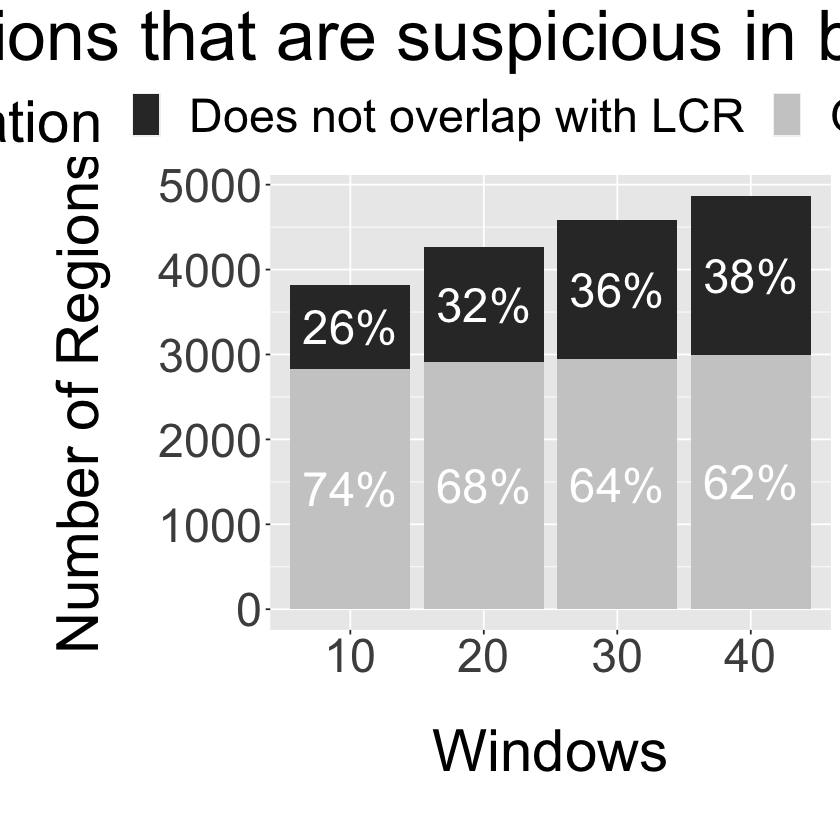

In [19]:
library(tidyverse)
library(data.table)
library(readxl)
library(dplyr)
library(stringr)
library(ggpubr)

#### Read in all the files and save to variable and find rows to find the number of indels in LCR

## define bp_range
bp_range = c("10", "20", "30", "40")

## define output_path
output_path=""
## define_date
date = ""

for (j in bp_range) {
  # get files
  total_df = paste0(output_path, date, "_sus_by_both_dfs_bp",j,".bed")

  overlap_file = paste0(output_path, date, "_LCR_intersect_", j,"_sus_in_both_dfs.bed")

  ## find total number of suspicious bins 
  n_total = paste0("total_bp_", j)

  assign( n_total , nrow(fread(total_df)))

  ## find total number of overlapping bins 
  n_overlap = paste0("overlap_bp", j)

  assign(n_overlap, nrow(fread(overlap_file)))

  print(paste0(n_overlap, ": ", get(n_overlap)))

  # get not overlapping
  n_not_overlap = paste0("not_overlap_bp_", j)

  assign( n_not_overlap, get(n_total) - get(n_overlap))

  print(paste0( n_not_overlap, ": ", get( n_not_overlap)))

  # get percentages of overlapping 
  prct_overlap = paste0("prct_overlap_bp_", j)

  assign(prct_overlap, paste0(round(get(n_overlap)/get(n_total) * 100, 0), "%"))

  print(paste0( prct_overlap, ": ", get( prct_overlap)))

  # get percentages of not overlaping 
  prct_not_overlap = paste0("prct_not_overlap_bp_", j)

  assign( prct_not_overlap, paste0(round(get(n_not_overlap)/get(n_total) * 100, 0), "%"))

  print(paste0( prct_not_overlap, ": ", get( prct_not_overlap)))
}

overlap_n = c(overlap_bp10, overlap_bp20, overlap_bp30, overlap_bp40)
overlap_pct = c(prct_overlap_bp_10, prct_overlap_bp_20, prct_overlap_bp_30, prct_overlap_bp_40)
not_overlap_n = c(not_overlap_bp_10, not_overlap_bp_20, not_overlap_bp_30, not_overlap_bp_40)
not_overlap_pct = c(prct_not_overlap_bp_10, prct_not_overlap_bp_20, prct_not_overlap_bp_30, prct_not_overlap_bp_40)

df_summary = data.frame(bp_range, overlap_n , overlap_pct, not_overlap_n, not_overlap_pct)
df_summary

#make graph

windows = c(rep(bp_range, 2))
region = c(rep("overlap", 4), rep("not overlap", 4))

num_indels = c(overlap_n, not_overlap_n)
prct_indels = c(overlap_pct, not_overlap_pct)


graph_df = data.frame(windows, region, num_indels, prct_indels)
graph_df

graph = ggplot(graph_df, aes(x = windows, y = num_indels, fill = region)) + geom_bar(stat = "identity", position = "stack") + labs(title = paste0("Regions that are suspicious in both datasets" ), y = "Number of Regions", x = "Windows", fill = "Location") +  geom_text(aes(label = prct_indels), color = "white", position = position_stack(vjust = 0.5), size = 10) + scale_fill_grey(labels = c( str_wrap(paste0("Does not overlap with LCR"), width = 40), str_wrap(paste0 ("Overlaps with LCR"), width = 40), str_wrap(paste0("Does not overlap with LCR"), width = 40), str_wrap(paste0 ("Overlaps with LCR"), width = 40))) + theme(text = element_text(size = 35), axis.title.y = element_text(margin = margin( 1, 1, 1, 1, "cm")), axis.title.x = element_text(margin = margin( 1, 1, 1, 1, "cm")), legend.position = "top", plot.title = element_text(hjust = 0.5))

graph

null_df = data.frame() 
null_figure_1 = ggplot(null_df) + labs(title = "Intersection of Suspicious Intervals") + theme(panel.background = element_rect(fill = 'white', colour = 'white')) + theme (plot.title = element_text(hjust = 0.5, size = 36, margin = margin( 1, 1, 1, 1, "cm")))

null_figure_2 = ggplot(null_df) + labs(title = "LCR Overlap Analysis") + theme(panel.background = element_rect(fill = 'white', colour = 'white')) + theme (plot.title = element_text(hjust = 0.5, size = 36, margin = margin( 1, 1, 1, 1, "cm"))) 

graph_output = ggarrange(ggarrange(print(null_figure_1), print(null_figure_2), nrow = 2, labels = c("A","B"), font.label = list(size = 32, color = "black")), print(graph), ncol = 2, labels = c("", "C"), font.label = list(size = 32, color = "black")) + theme(plot.margin = unit(c(2,2,2,2), "cm"))

ggsave("prct_sus_in_both_datasets_overlap_lcr.jpg", width = 70, height = 35, units = c("cm"), dpi = 300)
